# Clustering Consulting Project 

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

## Initialize

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd



def create_spark(table_name):
    
    data = sqlContext.sql(f"select * from {table_name}")
    data = spark.createDataFrame(data.rdd)
    
    return data



def kmeans_clustering(df, var1, var2, k, chosen_input_cols):
    # Assemble features
    assembler = VectorAssembler(inputCols=chosen_input_cols, outputCol="features_vec")
    scaler = StandardScaler(inputCol='features_vec', outputCol='features')
    data = assembler.transform(df)
    data = scaler.fit(data).transform(data)

    # Train KMeans model
    kmeans = KMeans(featuresCol="features", k=k)
    model = kmeans.fit(data)

    # Make predictions
    predictions = model.transform(data)
    
    cost = ClusteringEvaluator().evaluate(predictions)

    # Visualize clusters
    plt.figure()
    sns.scatterplot(data=predictions.toPandas(), x=var1, y=var2, hue="prediction", palette="Set2")
    
    return cost


    
    
    
    

## Evaluate Data

In [0]:
data = create_spark('hack_data')
data.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [0]:
data.columns

Out[13]: ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_vec. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_vec. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: Vector

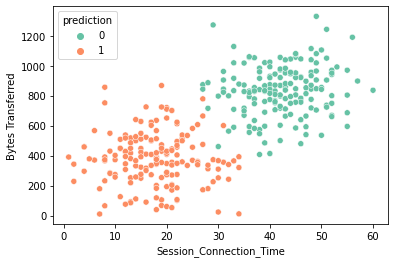

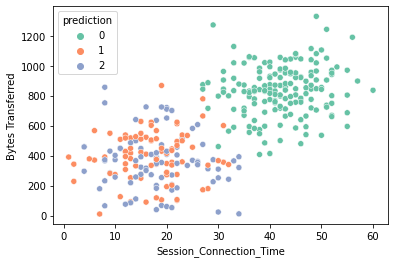

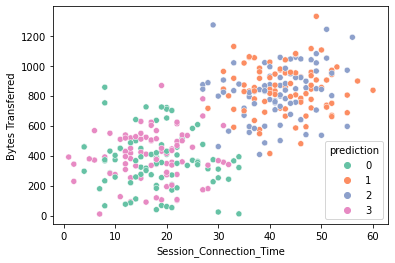

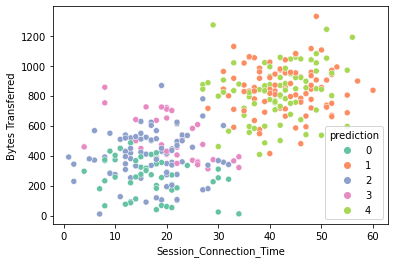

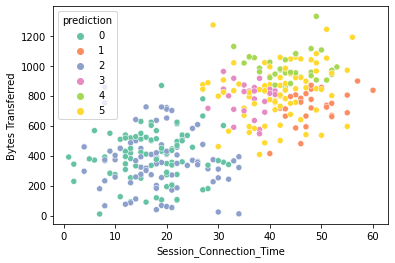

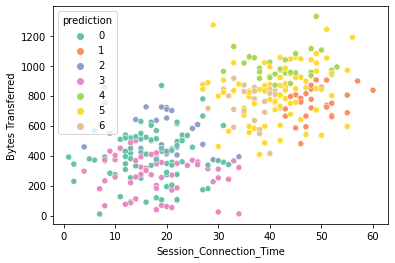

In [0]:

costs = []
k_s = [x + 2 for x in range(6)]
for k_val in range(6):
    
    cost = kmeans_clustering(data , 'Session_Connection_Time', 'Bytes Transferred', (k_val + 2) , ['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'])
    
    costs.append(cost)

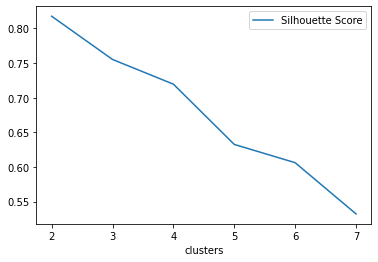

In [0]:
elbow = pd.DataFrame({'clusters': k_s,
                      'Silhouette Score': costs})

elbow.plot(kind= 'line', x = 'clusters', y = 'Silhouette Score');

# 2 has the highest silhouette score and so can be considered the best number of clusters, we can also see that visually in the graphs above!